In [1]:
import matplotlib
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import pandas as pd
import scipy.fftpack
import gc
import patched_gpr
np.random.seed(1)




logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['figure.figsize'] = [32.0, 16.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*2)

In [3]:
def adjust_ax_labels(axs, rng, n_ticks=8, hz=250):
    try:
        axs_iterator = iter(axs)
    except TypeError as te:
        axs_iterator = iter([axs])
    for ax in axs_iterator:
        ax.axis("off")
    ax.axis("on")
    x_ticks = np.linspace(rng[0],rng[1],n_ticks)
    x_tick_labels = x_ticks/hz
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(list(map(lambda x: "{:.01f}".format(x), x_tick_labels)))
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)        

In [4]:
#HB suggests using std(X)*n**(-1/5)... since std(X) depends crucially on the length of the signal, how can this help?

In [8]:
project_dir = "../data/todd_eeg_gpr_run2"
os.makedirs(project_dir, exist_ok=1)

In [9]:
data_dir = "/home/brown/disk2/eeg/Phasespace/Phasespace/data/eeg-text"

In [10]:
data_info = pd.read_csv(os.path.join(data_dir, "fileinformation.csv"), skiprows=1).iloc[:,2:]

In [11]:
data_info

,Unnamed: 2,Number of Records,Time of Seizure,Unnamed: 5,Point of Seizure,250
0,DAT.F00012,3963799,14040,NaN,3510000,3510000
1,DAT.F00013,3632699,12720,NaN,3180000,3180000
2,DAT.F00016,4447824,15960,NaN,3990000,3990000
3,DAT.F00017,1827224,0,NaN,0,0
4,DAT.F00018,2985924,10020,NaN,2505000,2505000
5,DAT.F00019,3692374,12960,NaN,3240000,3240000
6,DAT.F00020,3270974,11280,NaN,2820000,2820000
7,DAT.F00022,2120524,0,NaN,0,0
8,DAT.F00024,3378499,11700,NaN,2925000,2925000
9,DAT.F00026,3370999,0,NaN,0,0


In [12]:
WHICH_DATA_FILE=5

In [13]:
data_file = data_info.iloc[WHICH_DATA_FILE,0]

In [14]:
data_epipoint = data_info.iloc[WHICH_DATA_FILE,4]

In [15]:
data_epipoint

3240000

In [16]:
dat = np.loadtxt(os.path.join(data_dir, data_file))

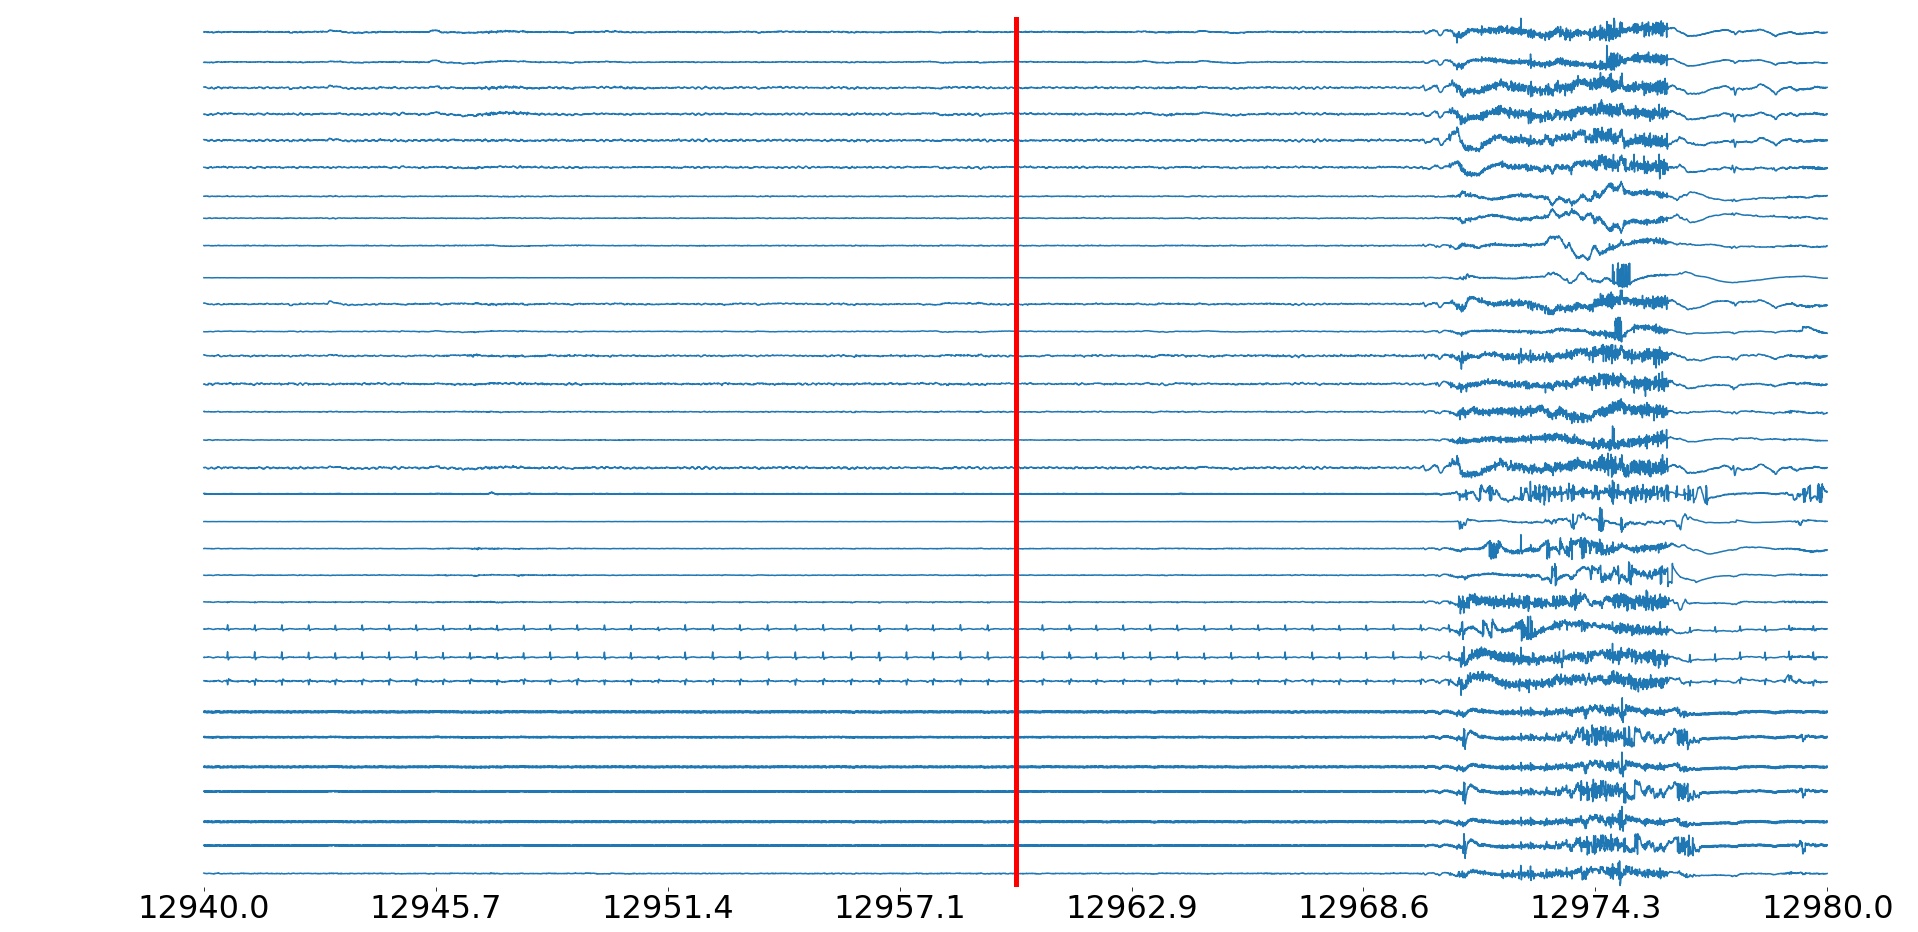

In [17]:
l = 5000
HZ = 250
fig, axs = plt.subplots(dat.shape[1], sharex=True, gridspec_kw={'hspace': 0})
rng = (max(0,data_epipoint-l), min(dat.shape[0], data_epipoint+l))
adjust_ax_labels(axs,rng,hz=HZ)
for var in range(dat.shape[1]):
    y = dat[slice(*rng),var]
    X = np.arange(*rng)
    axs[var].plot(X, y)
    axs[var].axvline(data_epipoint,c='r',lw=5)
plt.savefig(os.path.join(project_dir, "eeg{}_allchannels_rng{}.png".format(data_file, str(rng))))

In [18]:
import sklearn.gaussian_process as gp
import importlib
importlib.reload(local_models.local_models)
importlib.reload(patched_gpr)

<module 'patched_gpr' from '/home/brown/python_packages/patched_gpr/patched_gpr.py'>

In [19]:
class GPR(patched_gpr.GaussianProcessRegressor):
    def fit(self, X,y,sample_weight=None, **kwargs):
        if "beta0" in kwargs:
            self.kernel.theta = kwargs["beta0"]
            del kwargs["beta0"]
        the_model = super().fit(X,y,sample_weight, **kwargs)
        self.coef_ = the_model.kernel_.theta
        self.intercept_ = np.empty((0,))
        return the_model

In [20]:
kernel = np.sum((
    gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[1e-10,1e4]), 
    np.prod((
        gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,1000]),
        gp.kernels.RBF(length_scale=20., length_scale_bounds=[1,1000])
    )),
    gp.kernels.WhiteKernel(noise_level=1.0, noise_level_bounds=[1e-10,1000])
))

In [21]:
regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=7, alpha=0)

In [22]:
rng=(1000,2000)
X=np.arange(*rng)

In [23]:
exemplar_gpr = regressor.fit(X.reshape(-1,1), dat[slice(*rng),0],np.ones(rng[1]-rng[0]))

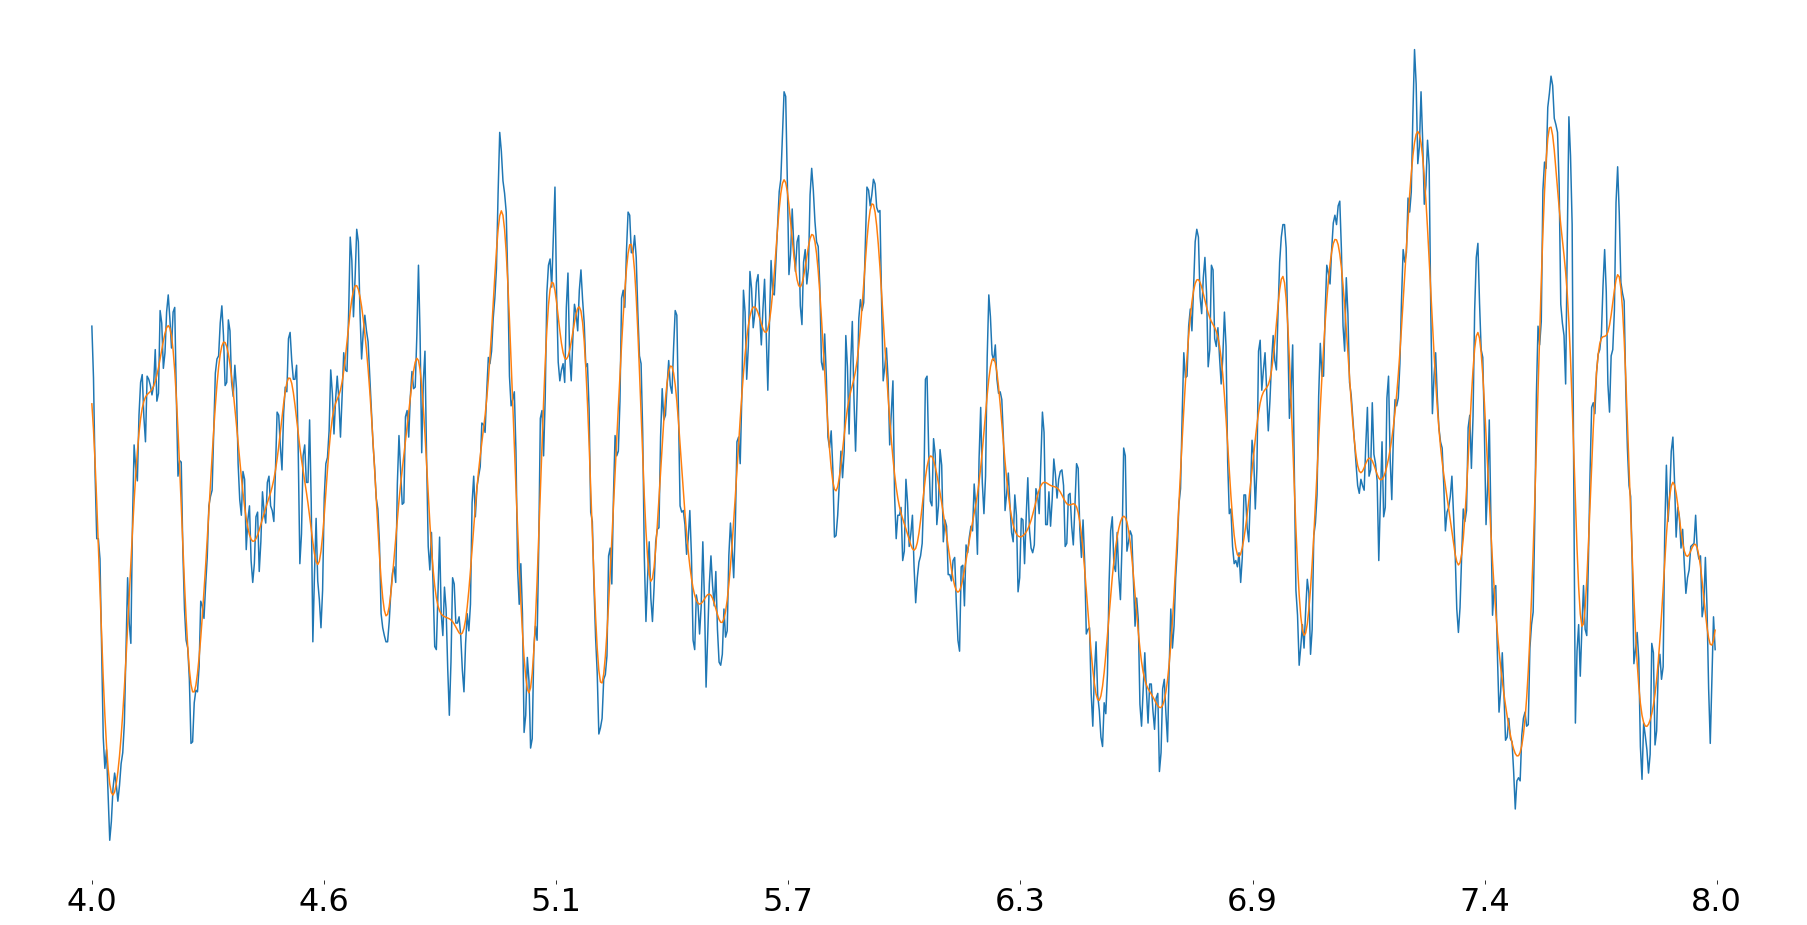

In [24]:
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,rng,hz=HZ)
axs.plot(X, dat[slice(*rng),0])
axs.plot(X, exemplar_gpr.predict(X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "exemplar_gpr_rng{}.png".format(str(rng))))

In [25]:
np.exp(exemplar_gpr.kernel_.theta)

array([7.28335492e-08, 1.00000000e+03, 5.63508528e+00, 7.31688613e+02])

In [26]:
logger.info("stuff")

In [27]:
#a computationally convenient approximation to the beta... sig on [0,1]
def kumaraswamy(sig,a=1.,b=1.):
    return a*b*sig**(a-1)*(1-sig**a)**(b-1)
def spectrum(sig, d):
    f = scipy.fftpack.rfftfreq(sig.size, d=d)
    y = scipy.fftpack.rfft(sig)
    return f, y
def kumaraswamy_filter(sig,d,a=1.,b=1.):
    f, y = spectrum(sig, d)
    max_f = np.max(f)
    kumaraswamy_filter = kumaraswamy(f/max_f,a,b)
    kumaraswamy_filter /= np.max(kumaraswamy_filter) #scale units
    y *= kumaraswamy_filter
    filtered_sig = scipy.fftpack.irfft(y)
    return filtered_sig

In [28]:
filtered_dat0 = kumaraswamy_filter(dat[:,0],1/HZ,1.2,10.)

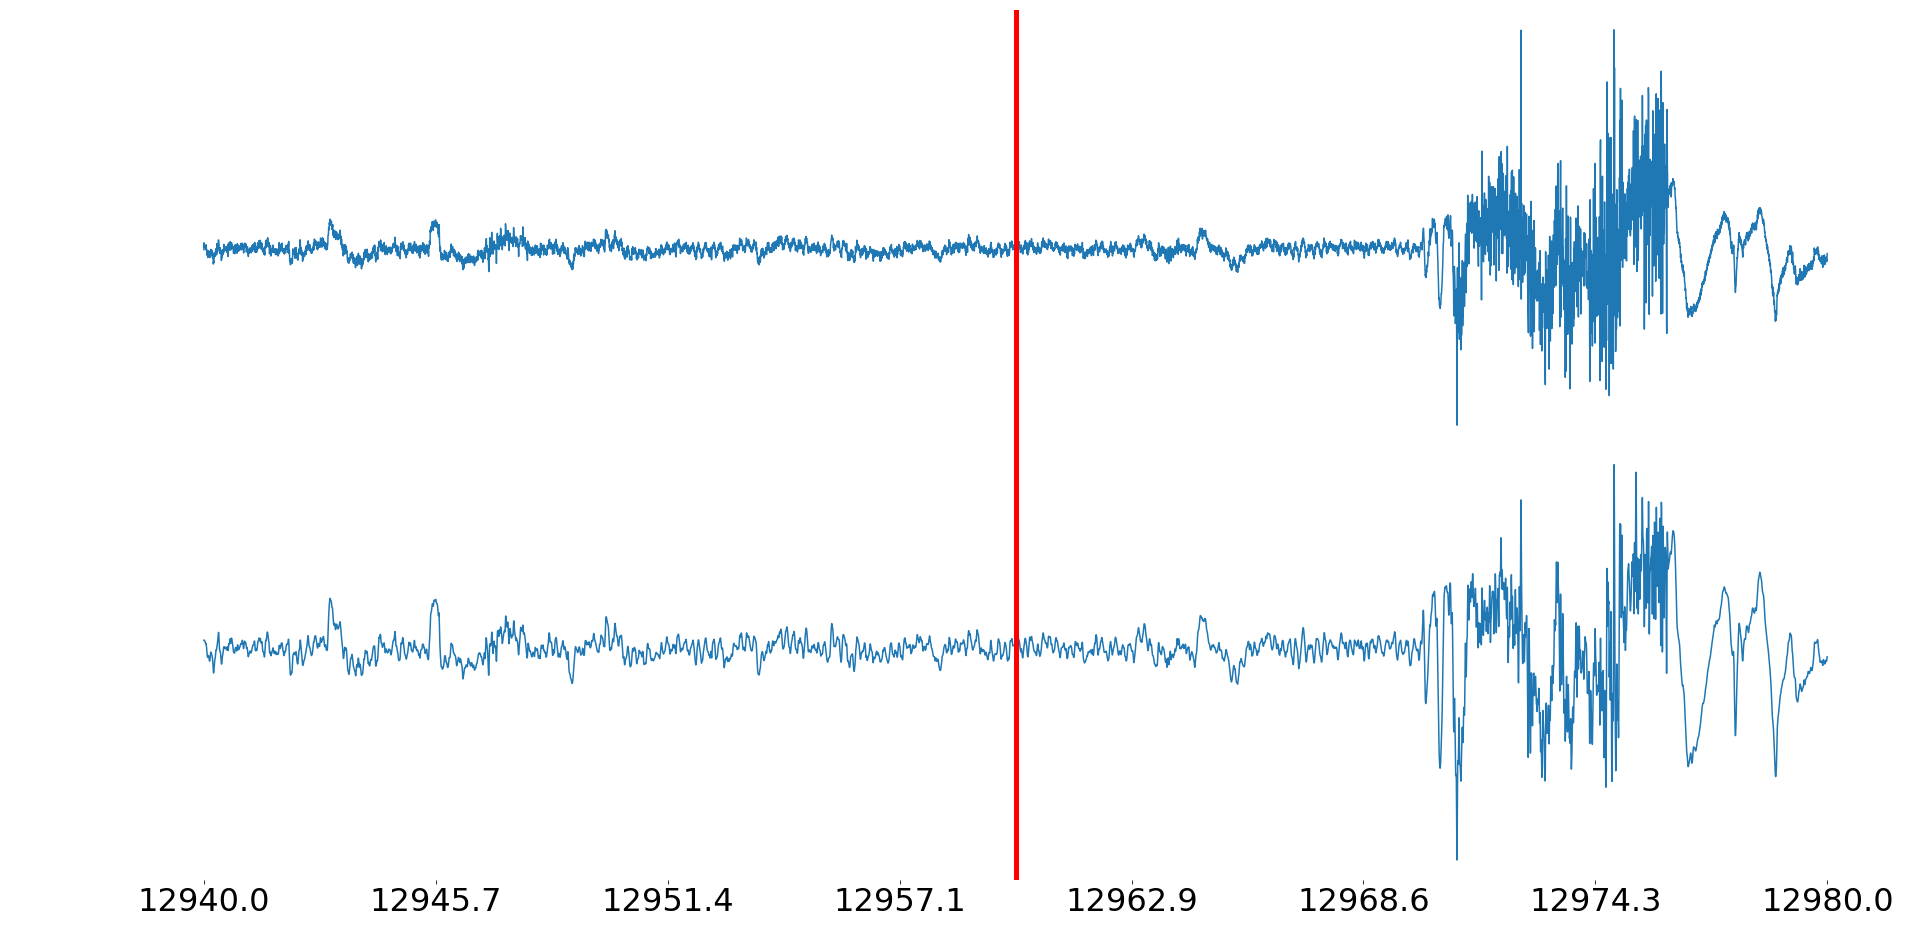

In [29]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
rng = (max(0,data_epipoint-l), min(dat.shape[0], data_epipoint+l))
X = np.arange(*rng)
adjust_ax_labels(axs,rng,hz=HZ)
axs[0].plot(X, dat[slice(*rng),0])
axs[1].plot(X, filtered_dat0[slice(*rng)])
for ax in axs:
    ax.axvline(data_epipoint,c='r',lw=5)
    ax.axvline(data_epipoint,c='r',lw=5)
plt.savefig(os.path.join(project_dir, "eeg12_firstchannel_filteredvunfiltered_rng{}.png".format(str(rng))))

In [30]:
filtered_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=7, alpha=0)

In [31]:
rng=(data_epipoint-1000,data_epipoint+1000)
X = np.arange(*rng)

In [32]:
filtered_exemplar_gpr = filtered_regressor.fit(X.reshape(-1,1), filtered_dat0[slice(*rng)],np.ones(rng[1]-rng[0]))

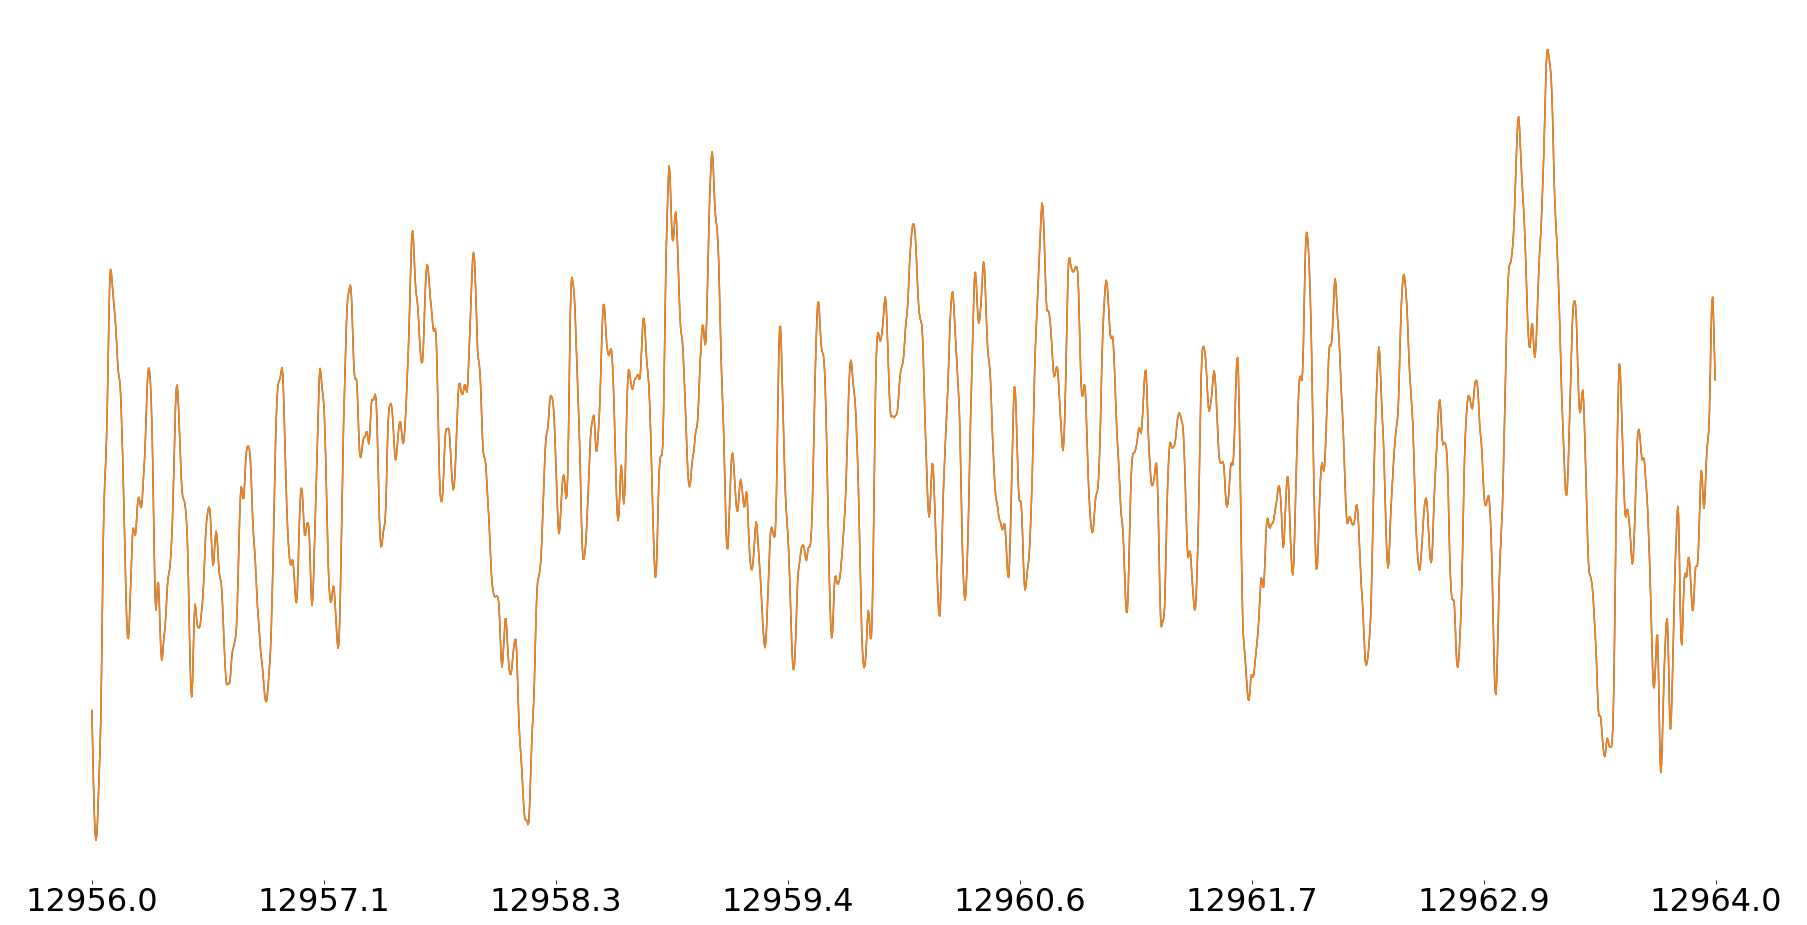

In [33]:
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,rng,hz=HZ)
axs.plot(X, filtered_dat0[slice(*rng)])
axs.plot(X, filtered_exemplar_gpr.predict(X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "filtered_exemplar_gpr_rng{}.png".format(str(rng))))

In [34]:
np.exp(filtered_exemplar_gpr.kernel_.theta)

array([1.06869731e-06, 1.00000000e+03, 2.88986494e+00, 1.00000000e-10])

In [45]:
filtered_local_regressor = GPR(kernel=filtered_exemplar_gpr.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
X = np.arange(filtered_dat0.shape[0]*1.).reshape(-1,1)
index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
y = filtered_dat0
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=1000)
filtered_gpr_models = local_models.local_models.LocalModels(filtered_local_regressor)
filtered_gpr_models.fit(X,y,index=index)

In [50]:
subsample_rate=25
rng = (max(0,data_epipoint-l), min(dat.shape[0], data_epipoint+l))
subsample_rng = (np.array(rng)/subsample_rate).astype(int)

In [51]:
rng

(3235000, 3245000)

In [ ]:
filtered_gpr_params = filtered_gpr_models.transform(X[rng[0]:rng[1]:subsample_rate,:],r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int((subsample_rng[1] - subsample_rng[0])/10))

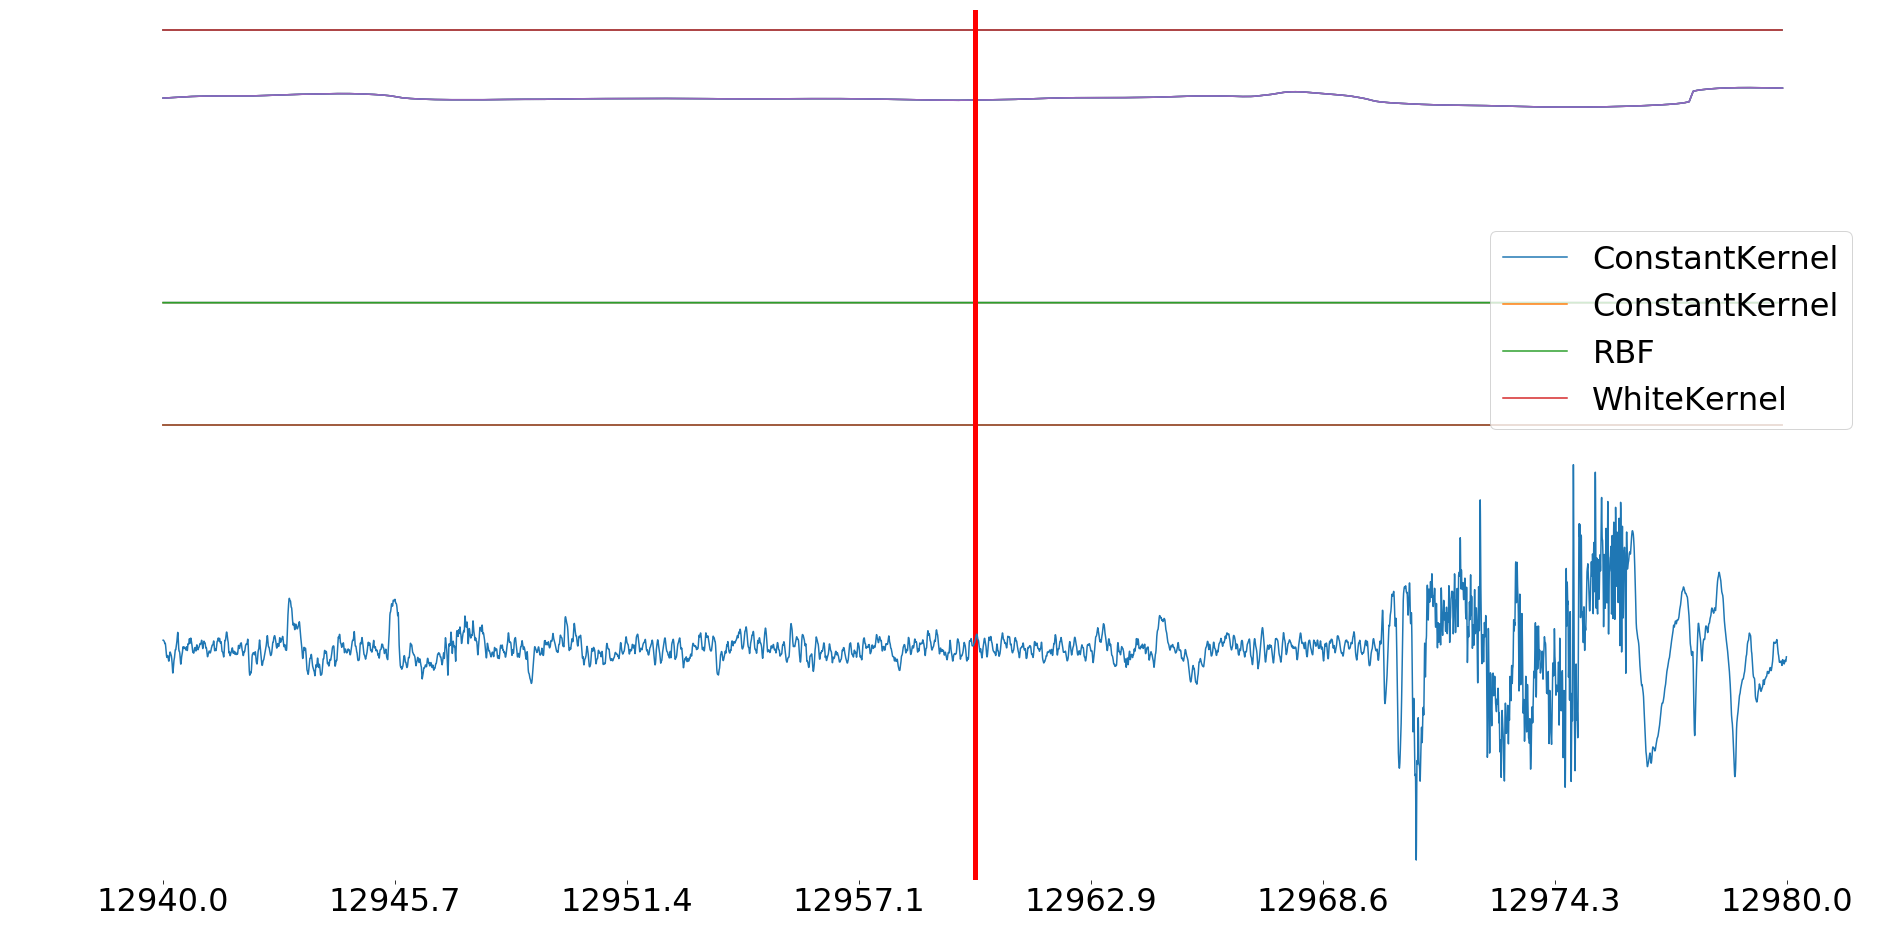

In [52]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,rng,hz=HZ)
for var in range(filtered_gpr_params.shape[1]):
    axs[0].plot(X[rng[0]:rng[1]:subsample_rate],filtered_gpr_params)
for ax in axs:
    ax.axvline(data_epipoint,c='r',lw=5)
axs[1].plot(X[rng[0]:rng[1]],filtered_dat0[rng[0]:rng[1]])
axs[0].legend(list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])),loc="lower right")
plt.savefig(os.path.join(project_dir, "filtered_gpr_params_subsamplerate{:07d}_kernel{}.png".format(subsample_rate, str(lm_kernel))))

In [ ]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,rng,hz=HZ)
artists = []
for var in range(filtered_gpr_params.shape[1]):
    param_artist = axs[0].plot(X[::subsample_rate],
                     filtered_gpr_params[subsample_rng[0]:subsample_rng[1],var])
    artists.append(param_artist[0])
for ax in axs:
    vline_artist = ax.axvline(data_epipoint,c='r',lw=5)
artists.append(vline_artist)
data_artist = axs[1].plot(X,filtered_dat0[rng[0]:rng[1]])
artists.append(data_artist[0])
print(artists)
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])) + ["ictal point", "filtered eeg"],loc="lower right")
plt.savefig(os.path.join(project_dir, "epipoint_filtered_gpr_params_subsamplerate{:07d}_kernel{}.png".format(subsample_rate, str(lm_kernel))))

In [374]:
local_regressor = GPR(kernel=exemplar_gpr.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)

In [375]:
X = np.arange(dat.shape[0]*1.).reshape(-1,1)
index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
y = dat[:,0]
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=500)
gpr_models = local_models.local_models.LocalModels(local_regressor)
gpr_models.fit(X,y,index=index)

In [376]:
X.shape

(3692374, 1)

In [502]:
subsample_rate=1000

In [ ]:
gpr_params = gpr_models.transform(X[::subsample_rate,:],r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int(X.shape[0]/10/subsample_rate))

In [384]:
gpr_params.shape

(370, 5)

In [385]:
np.exp(gpr_params[10])

array([1.00000000e-03, 1.00000000e+03, 7.10191755e+00, 2.16019629e+01,
       5.91177782e+00])

In [386]:
kernel

1**2 + 1**2 * RBF(length_scale=20) + 1**2 * WhiteKernel(noise_level=1)

NameError: name 'gpr_params' is not defined

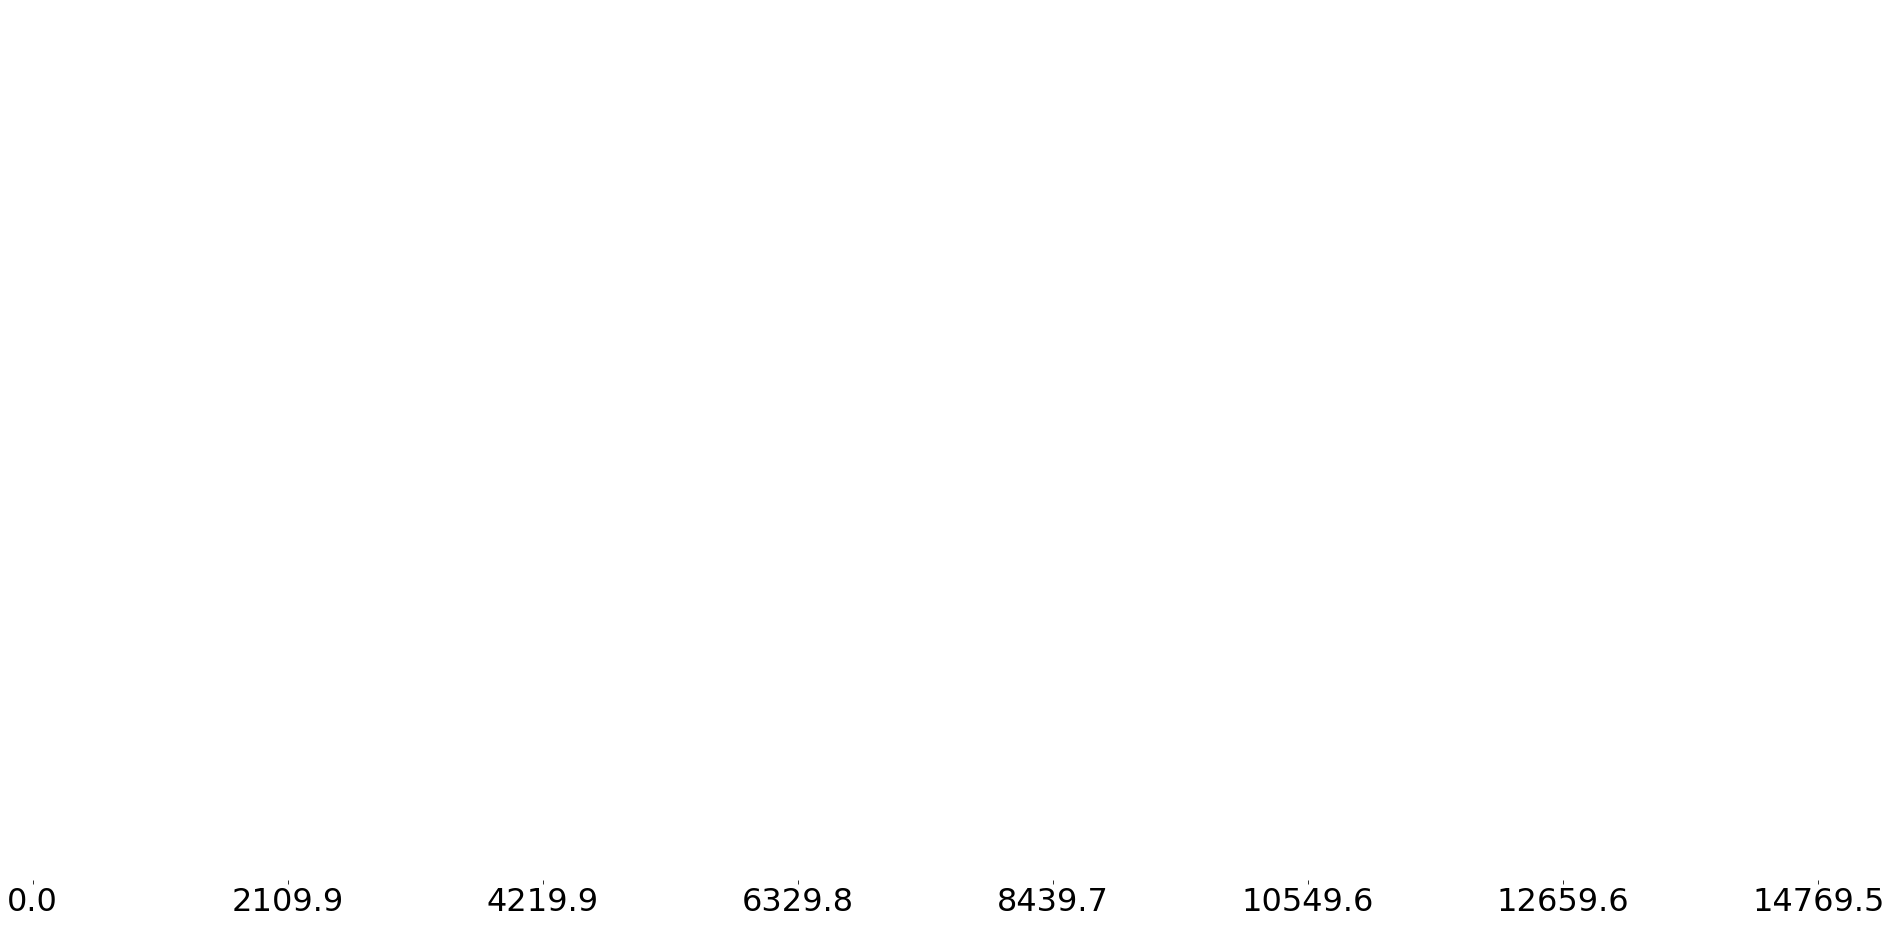

In [42]:
rng=(0,dat.shape[0])
X=np.arange(*rng)
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,rng,hz=HZ)
for var in range(gpr_params.shape[1]):
    axs.plot(X[::subsample_rate],gpr_params[:,var])
axs.axvline(data_epipoint,c='r',lw=5)
axs.legend(list(map(lambda x: type(x).__name__, patched_gpr.decompose_kernels(kernel))),loc="lower right")
plt.savefig(os.path.join(project_dir, "gpr_params_subsamplerate{:07d}_kernel{}.png".format(subsample_rate, str(lm_kernel))))